In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# os.environ['XLA_FLAGS'] ='--xla_gpu_deterministic_ops=true'


os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"

import torch
torch.multiprocessing.set_start_method('spawn')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"                                        │
│   10                                                                                             │
│   11 import torch                                                                                │
│ ❱ 12 torch.multiprocessing.set_start_method('spawn')                                             │
│   13                                                                                             │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/multiprocessing/context.py:247 in     │
│ set_start_method                                                                                 │
│                                                                                                  │
│   244 │                                                                                          │
│   245 │   def set_start_method(self, method, force=False):                                       │
│   246 │   │   if self._actual_context is not None and not force:                                 │
│ ❱ 247 │   │   │   raise RuntimeError('context has already been set')                             │
│   248 │   │   if method is None and force:                                                       │
│   249 │   │   │   self._actual_context = None                                                    │
│   250 │   │   │   return                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: context has already been set

In [46]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
sys.path.append(os.path.join(parent_folder_path, submodule_name))

print(sys.path)

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderBookArrays as job

['/data1/sascha/LOBS5/lob', '/data1/sascha/AlphaTrade', '/home/sascha/miniconda3/envs/alphatrade_new/lib/python310.zip', '/home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10', '/home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/lib-dynload', '', '/home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages', '/data1/sascha/LOBS5', '/data1/sascha/LOBS5/AlphaTrade', '/homes/80/kang/LOBS5/', '/data1/sascha/LOBS5/AlphaTrade', '/data1/sascha/LOBS5/AlphaTrade', '/data1/sascha/LOBS5', '/data1/sascha/LOBS5/AlphaTrade']


In [47]:
# from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
# from functools import partial
# from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# from line_profiler import LineProfiler

import jax
import jax.numpy as jnp
from jax.nn import one_hot
# from jax import random
# from jax.scipy.linalg import block_diag
# from flax import jax_utils
# from flax.training import checkpoints
# import orbax

#from lob.lob_seq_model import BatchLobPredModel
# from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import *
# from s5.ssm_init import make_DPLR_HiPPO
# from s5.dataloading import make_data_loader
# from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
# from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
# import inference
from lob import inference_no_errcorr as inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_metadata, load_args_from_checkpoint
# import lob.encoding as encoding

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()




# Forecasting

In [48]:
import lob.evaluation as eval
from preproc import transform_L2_state

In [49]:
n_gen_msgs = 1000  #500 # how many messages to generate into the future
n_messages_conditional = 500
n_eval_messages = 1000  # how many to load from dataset 
eval_seq_len = (n_eval_messages-1) * Message_Tokenizer.MSG_LEN
cond_seq_len = (n_messages_conditional) * Message_Tokenizer.MSG_LEN

data_levels = 10
# TODO: deprecated - remove from functions
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

n_vol_series = 500  # how many book volume series model uses as input

v = Vocab()
n_classes = len(v)
book_dim = 501 #b_enc.shape[1]
eval_book_seq_len = eval_seq_len


rng = jax.random.key(42)
rng, rng_ = jax.random.split(rng)
sample_top_n = 5
tick_size = 100

In [50]:
v.DECODING

{}

In [51]:
# entire test set after training data
stock='GOOG'


if stock == 'GOOG':
    data_dir = '/data1/sascha/data/GOOG2017to2019'
    ckpt_path='/data1/sascha/data/checkpoints/honest-oath-159_3kn3xbd5'
elif stock == 'INTC':
    raise NotImplementedError("Nothing trained for INTC yet")
elif stock == 'TSLA':
    raise Warning("Saved Model was trained on GOOGLE data. Generating for TSLA")
    data_dir = '/data1/sascha/data/lobster_proc'
    ckpt_path = '/data1/sascha/data/checkpoints/honest-oath-159_3kn3xbd5' # Dummy model trained on just 5 days... for debugging. 



In [52]:
args = load_metadata(ckpt_path)
ds = inference.get_dataset(data_dir, n_messages_conditional, n_eval_messages)
args.num_devices=1
args.bsz=1


new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=eval_seq_len,
    book_dim=book_dim,
    book_seq_len=eval_book_seq_len,
)



ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    train=False,
)
state = ckpt['model']


import chex
chex.clear_trace_counter()

Dummy input shapes (msg,book) ((Array(1, dtype=int32, weak_type=True), Array(21978, dtype=int32, weak_type=True)), 
 (Array(1, dtype=int32, weak_type=True), Array(21978, dtype=int32, weak_type=True), Array(501, dtype=int32, weak_type=True)))
(12012, 512)
configuring standard optimization setup
[*] Trainable Parameters: 25699641
(12012, 512)
(1, 12012, 512)


In [53]:
# jax.tree_util.tree_map(lambda x: x.shape,state)
ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    train=False,
)
state = ckpt['model']
print(state.params['message_encoder']['encoder']['embedding'].shape)


(12012, 512)


In [54]:
len(ds)

230656

In [55]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='generation_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.WARNING)

In [56]:
model = model_cls(training=False, step_rescale=1.0)


In [57]:
i = 230000
l2_state_n = 20
# m_seq conditional (500) and eval messages (100) tokenised
# _ Target: scalar placeholder. 
# b_seq_pv raw form of book 4*nlvl+1
# msg_seq_raw msgs after preproc but before tokenising
# book_l2_init: n-1 book state... needs attention for unconditional case. 
m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]


#  b_seq : transformed into 501 size array. 
b_seq = jnp.array(transform_L2_state(b_seq_pv, n_vol_series, 100))
b_seq=jax.device_put(b_seq,device=jax.devices()[0])
m_seq_raw_inp = msg_seq_raw[: n_messages_conditional]

# with jax.disable_jit():

# initialise simulator
sim_init, sim_state_init = inference.get_sim(
    book_l2_init,  # book state before any messages
    m_seq_raw_inp, # messages to replay to init sim
)
# # book state after initialisation (replayed messages)
# l2_book_state_init = sim_init.get_L2_state(sim_state_init, l2_state_n)


m_seq=jnp.concatenate([jnp.array([v.START_TOK]),m_seq])

In [58]:
msg_seq_raw

inference.msg_to_lobster_format(msg_seq_raw).price.describe()

count    1.500000e+03
mean     1.352495e+07
std      9.454183e+03
min      1.350100e+07
25%      1.351680e+07
50%      1.352750e+07
75%      1.353350e+07
max      1.354050e+07
Name: price, dtype: float64

In [59]:
book_l2_init

array([13525000,      100, 13516400,       10, 13525100,      100,
       13515400,       10, 13525200,       67, 13515300,      100,
       13526900,      100, 13513800,       35, 13527800,       11,
       13512300,       60, 13528000,        5, 13509700,       10,
       13528400,      100, 13509400,      100, 13528700,       39,
       13509100,       99, 13529700,        4, 13507800,        1,
       13529900,      100, 13505400,       40])

In [60]:
np.abs(msg_seq_raw[:,4]).min()

Array(1, dtype=int32)

In [61]:
b_seq_pv[:,1]

array([13525000, 13525000, 13525000, ..., 13533600, 13533600, 13533600])

In [62]:
init_hidden=model.initialize_carry(args.bsz//args.num_devices,
                                        hidden_size=(args.ssm_size_base // pow(2,int(args.conj_sym))),
                                        n_message_layers=args.n_message_layers,
                                        n_book_pre_layers=args.n_book_pre_layers ,
                                        n_book_post_layers=args.n_book_post_layers,
                                        n_fused_layers=args.n_layers,)

In [84]:
msgs_decoded, l2_book_states, num_errors,msgs_tokens = inference.generate(
    sim_init,
    state,
    model,
    args.batchnorm,
    v.ENCODING,
    sample_top_n,
    tick_size,
    jax.device_put(jnp.array(m_seq[:11000+1])),#include start token
    jax.device_put(jnp.array(b_seq[:500])),
    1000, #n_gen_msgs
    sim_state_init,
    rng,
    init_hidden,
    True,
    (0,0),
)


-2
-2
998
-2
996
-900011
-2
993
-2
991
-2
989
-2
987
986
985
-2
983
-2
981
-2
979
-2
977
-2
975
-2
973
-2
971
-2
969
-2
967
-2
965
-2
963
-2
961
-2
959
-2
957
-2
955
-2
953
-2
951
-2
949
948
-2
946
945
-2
943
-2
-2
940
-2
938
937
-2
935
-2
933
-2
931
-2
-2
928
-2
926
-2
924
923
-2
921
-2
919
-2
917
-2
915
-2
913
-2
911
-2
909
908
-2
-2
-2
904
-2
902
-2
900
-2
-2
897
-2
895
894
893
892
891
-2
889
-2
887
-2
885
-2
-2
882
-2
-2
879
878
877
-2
-2
874
873
-2
871
-2
-2
-2
867
-2
865
-2
863
862
861
-2
859
-2
857
856
-2
854
-2
852
-2
-2
849
848
847
-2
845
-2
843
842
-2
-2
839
838
-2
-2
835
-2
-2
832
-2
830
-2
828
-2
826
825
-2
823
-2
821
-2
819
-2
817
816
815
-2
813
-2
811
-2
809
808
-2
806
-2
804
803
802
801
-2
799
-2
-2
796
-2
794
-2
792
-2
790
789
788
787
-2
785
784
783
-2
-2
-2
779
-2
-2
776
775
-2
773
-2
771
-2
-2
768
-2
-2
-2
764
-2
762
761
760
759
-2
757
756
-2
754
-2
752
751
-2
-2
748
-2
746
745
-2
743
-2
-2
740
739
-2
-2
736
-2
734
-2
732
731
-2
729
-2
727
-2
725
724
-2
722
-2
720
719

In [85]:
num_errors

Array(86, dtype=int32)

In [86]:
inference.msg_to_lobster_format(msgs_decoded)

,time,event_type,order_id,size,price,direction
0,36472.912565519,3,-2,1,13531700,-1
1,36472.912565749,3,-2,1,13531400,-1
2,36472.912569879,1,998,5,13531600,-1
3,36472.912571059,3,-2,1,13531500,-1
4,36472.912571059,1,996,1,13531400,-1
...,...,...,...,...,...,...
995,36522.598174920,1,5,31,13415600,-1
996,36523.420009741,1,4,31,13415600,-1
997,36525.254844575,1,3,31,13415600,-1
998,36527.089666409,1,2,31,13415600,-1


In [70]:
msgs_decoded[:10]

Array([[       -2,         3,         0,  13531700,        65,         1,
                0,      5130,     36472, 912565519,         0,     -9999,
                0,         0],
       [       -2,         3,         0,  13531400,        62,         1,
                0,       230,     36472, 912565749,         0,     -9999,
                0,         0],
       [        3,         1,         0,  13531600,        64,         5,
                0,      4130,     36472, 912569879,         0,     -9999,
                0,         0],
       [       -2,         3,         0,  13531500,        63,         1,
                0,      1180,     36472, 912571059,        63,         1,
            49972, 562559653],
       [        1,         1,         0,  13531400,        62,         1,
                0,         0,     36472, 912571059,         0,     -9999,
                0,         0]], dtype=int32)

In [82]:
pd.DataFrame(l2_book_states).loc[:,0:16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,13529600,14,13520900,11,13529700,4,13517700,16,13531800,15,13517200,1,13533100,100,13516400,3,13533500
1,13529600,14,13520900,11,13529700,4,13517700,16,13531800,15,13517200,1,13533100,100,13516400,3,13533500
2,13529600,14,13520900,11,13529700,4,13517700,16,13531600,5,13517200,1,13531800,15,13516400,3,13533100
3,13529600,14,13520900,11,13529700,4,13517700,16,13531600,5,13517200,1,13531800,15,13516400,3,13533100
4,13529600,14,13520900,11,13529700,4,13517700,16,13531400,1,13517200,1,13531600,5,13516400,3,13531800


In [ ]:
v.ENCODING['price']


from encoding import decode

print(decode(11135,*v.ENCODING['price']))
decode(12008,*v.ENCODING['sign'])


In [ ]:
v.ENCODING['sign']

In [ ]:
np.set_printoptions(edgeitems=5)
jnp.set_printoptions(edgeitems=5)

In [ ]:
11008, ..., 12003, 12004, 12005, 12006,12007

In [ ]:
jax.device_put(jnp.array(m_seq[:11000+1]))#[:-1]
valh.get_field_from_idx(21)
valh.get_idx_from_field("time_ns")
valh.get_valid_toks_for_field(['time_ns'])

In [ ]:
tuple(tuple(
        v.ENCODING[Message_Tokenizer.FIELD_ENC_TYPES[field]].keys())
          for field in ['time_s'])

In [ ]:
v.DECODING

In [ ]:
for field in ['time_s']:
    print(field)

In [ ]:
inference.msg_to_lobster_format( msgs_decoded[0:10])


In [ ]:
inference.book_to_lobster_format(l2_book_states[0:10,15:35])

In [ ]:
n_samples = 160
batch_size = 16

# m_seq_gen, b_seq_gen, msgs_decoded, l2_book_states, num_errors = inference.sample_new(
# saves data to disk
inference.sample_new(
    n_samples,
    batch_size,
    ds,
    rng,
    cond_seq_len,
    n_eval_messages,
    n_gen_msgs,
    state,
    model,
    args.batchnorm,
    v.ENCODING,
    stock,
    save_folder='/data1/sascha/data/GOOG_eval_new',
    sample_top_n=sample_top_n,
    args=args,
    conditional= True,
    init_time = (jnp.array([0]),jnp.array([0])),
)

In [87]:
gen_book=pd.read_csv("/data1/sascha/data/GOOG_eval_new/data_gen/GOOG_2017-02-28_orderbook_real_id_3100_gen_id_0.csv",header=None)
real_book=pd.read_csv("/data1/sascha/data/GOOG_eval_new/data_real/GOOG_2017-02-28_orderbook_real_id_3100.csv",header=None)
cond_book=pd.read_csv("/data1/sascha/data/GOOG_eval_new/data_cond/GOOG_2017-02-28_orderbook_real_id_3100.csv",header=None)

gen_msg=pd.read_csv("/data1/sascha/data/GOOG_eval_new/data_gen/GOOG_2017-02-28_message_real_id_3100_gen_id_0.csv",header=None)
real_msg=pd.read_csv("/data1/sascha/data/GOOG_eval_new/data_real/GOOG_2017-02-28_message_real_id_3100.csv",header=None)
cond_msg=pd.read_csv("/data1/sascha/data/GOOG_eval_new/data_cond/GOOG_2017-02-28_message_real_id_3100.csv",header=None)




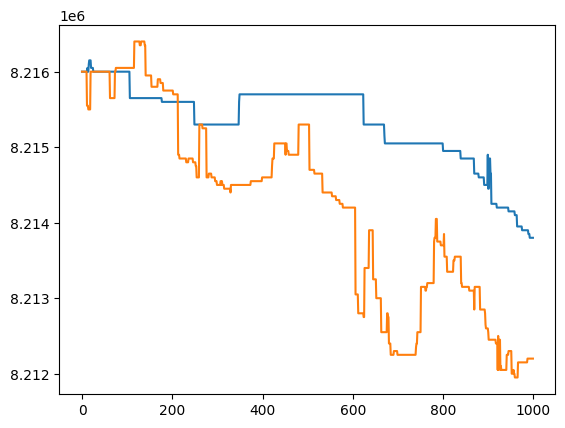

In [97]:
plt.plot((gen_book.loc[:,0]+gen_book.loc[:,2])/2)
plt.plot((real_book.loc[:,0]+real_book.loc[:,2])/2)

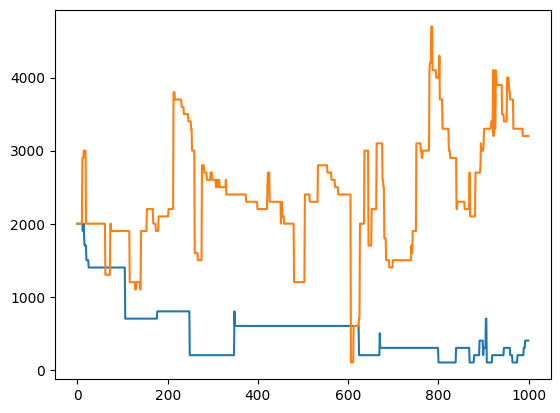

In [95]:
plt.plot((gen_book.loc[:,0]-gen_book.loc[:,2]))
plt.plot((real_book.loc[:,0]-real_book.loc[:,2]))

In [92]:
gen_book.loc[:,0]

0      8217000
1      8217000
2      8217000
3      8217000
4      8217000
        ...   
995    8214000
996    8214000
997    8214000
998    8214000
999    8214000
Name: 0, Length: 1000, dtype: int64

In [89]:
gen_msg

,0,1,2,3,4,5
0,47842.118058,1,1000,100,8217200,-1
1,47842.119098,4,999,5,8214900,1
2,47842.119099,4,998,10,8214900,1
3,47842.119099,4,997,6,8214900,1
4,47842.149098,4,996,10,8214900,1
...,...,...,...,...,...,...
995,47901.274019,1,5,31,8119900,-1
996,47903.108854,1,4,31,8119900,-1
997,47904.943689,1,3,31,8119900,-1
998,47906.765523,1,2,31,8119900,-1


In [90]:
sim_init, sim_state_init = inference.get_sim(
    jnp.array(cond_book.loc[0],dtype=int),  # book state before any messages
    jnp.array(cond_msg), # messages to replay to init sim
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 sim_init, sim_state_init = inference.get_sim(                                                │
│   2 │   jnp.array(cond_book.loc[0],dtype=int),  # book state before any messages                 │
│   3 │   jnp.array(cond_msg), # messages to replay to init sim                                    │
│   4 )                                                                                            │
│                                                                                                  │
│ /data1/sascha/LOBS5/lob/inference_no_errcorr.py:173 in get_sim                                   │
│                                                                                                  │
│    170 │   # replay sequence in simulator (actual)                                               │
│    171 │   # so that sim is at the same state as the model                                       │
│    172 │   replay = msgs_to_jnp(replay_msgs_raw)                                                 │
│ ❱  173 │   sim_state = sim.process_orders_array(sim_state, replay)                               │
│    174 │   return sim, sim_state                                                                 │
│    175                                                                                           │
│    176 get_sims_vmap = jax.jit(                                                                  │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/traceback_util │
│ .py:179 in reraise_with_filtered_traceback                                                       │
│                                                                                                  │
│   176   def reraise_with_filtered_traceback(*args, **kwargs):                                    │
│   177 │   __tracebackhide__ = True                                                               │
│   178 │   try:                                                                                   │
│ ❱ 179 │     return fun(*args, **kwargs)                                                          │
│   180 │   except Exception as e:                                                                 │
│   181 │     mode = _filtering_mode()                                                             │
│   182 │     if _is_under_reraiser(e) or mode == "off":                                           │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/pjit.py:305 in │
│ cache_miss                                                                                       │
│                                                                                                  │
│    302                                                                                           │
│    303   @api_boundary                                                                           │
│    304   def cache_miss(*args, **kwargs):                                                        │
│ ❱  305 │   outs, out_flat, out_tree, args_flat, jaxpr, attrs_tracked = _python_pjit_helper(      │
│    306 │   │   jit_info, *args, **kwargs)                                                        │
│    307 │   executable = _read_most_recent_pjit_call_executable(jaxpr)                            │
│    308 │   maybe_fastpath_data = _get_fastpath_data(                                             │
│                                                            

In [33]:
jnp.array(gen_msg.loc[:1],dtype=int)

Array([[  39684,       1,    1000,       1, 8177600,      -1],
       [  39684,       3,      -1,       1, 8177600,      -1]],      dtype=int32)

In [ ]:
    # feed message to simulator, updating book state
    sim_state = sim_init.process_order_array(sim_state_init, jnp.array(gen_msg.loc[:1]))

    # debug('trades', _trades)

    # get current mid price from simulator
    p_mid_new = _get_new_mid_price(sim, sim_state, p_mid, tick_size)
    # jax.debug.print('p_mid_new {}', p_mid_new)

    # price change in ticks
    p_change = ((p_mid_new - p_mid) // tick_size)#.astype(jnp.int32)

    # get new book state
    book_l2 = sim.get_L2_state(sim_state, l2_state_n)
    # l2_book_states.append(book_l2)